In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lvc.datasets.vimeo90k import Vimeo90kDatasetConsecutive, Vimeo90kDatasetIntervals

In [3]:
from matplotlib import pyplot as plt
from torchvision import transforms
import random
import math

In [4]:
paths = ('/Users/begaintj/data/vimeo90k/vimeo_septuplet/', '/data/lvc/originals/vimeo_septuplet/')

for p in paths:
    try:
#         dataset = Vimeo90kDatasetIntervals(p, patch_size=(256, 384), intervals=[3])
        dataset = Vimeo90kDatasetIntervals(p, patch_size=(256, 384), intervals=[1,2,3], split='train')
#         dataset = Vimeo90kDatasetIntervals(p, patch_size=(256, 448), intervals=[1,2,3], split='train')
        break
    except ValueError:
        continue

In [5]:
print(len(dataset))

64612


In [6]:
sample = dataset[0]
print(len(sample))

3


In [7]:
len([item.flip(-1) for item in sample])

3

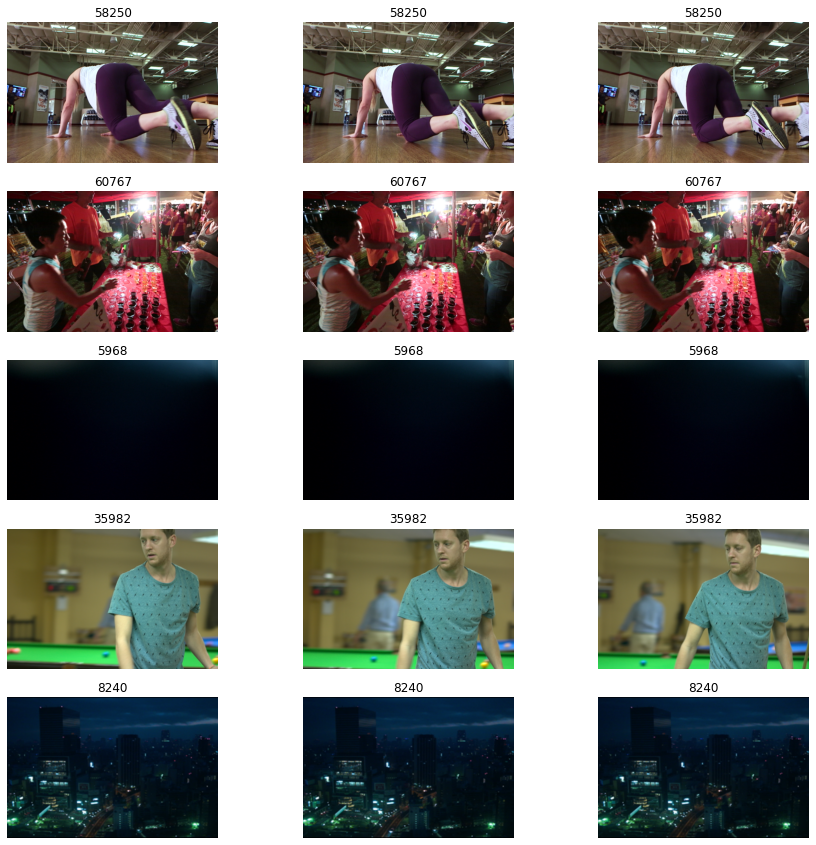

In [8]:
N = 5
fig, axes = plt.subplots(5, len(sample), figsize=(5*len(sample), 3*N))
for i in range(N):
    idx = random.randint(0, len(dataset))
    sample = dataset[idx]
#     sample = [item.flip(-1) for item in sample]
    for c, (ax, tensor) in enumerate(zip(axes[i], sample)):
        ax.imshow(transforms.ToPILImage()(tensor))
        ax.set_title(idx)
        ax.axis('off')

## Load model from checkpoint

In [9]:
from lvc.models.networks.video.ssf import google2020_flow
import torch
# path = '/home/begaintj/dev/learned-video-compression/logs/lvc/google2020_flow-0.01230-1e-4-8-83c64a84-2021-07-26-10h22/ckpt_last_model.pth.tar'
# path = '/home/begaintj/dev/learned-video-compression/logs/lvc/google2020_flow-0.01230-1e-4-8-83c64a84-2021-07-27-15h34/ckpt_last_model.pth.tar'
path = '/home/begaintj/dev/learned-video-compression/logs/lvc/google2020_flow-0.01230-1e-5-8-6718bd33-2021-07-28-19h04/ckpt_last_model.pth.tar'
device = 'cuda'

net = google2020_flow()
net.load_state_dict(torch.load(path, map_location=device)['network'])
net.eval()
print(net.training)

False


## Select random sample

In [30]:
idx = random.randint(0, len(dataset))
# idx = 64314
idx=33533
sample = dataset[idx]

In [31]:
print(idx)

33533


## Inference

In [32]:
with torch.no_grad():
    data = [x.unsqueeze(0) for x in sample]
    out = net(data)

In [33]:
for a, b in zip(data, out['x_hat']):
    print('{:.3f} dB'.format(-10*torch.log10((a-b).pow(2).mean()).item()))

34.666 dB
35.783 dB
35.519 dB


## Detailed inference

In [39]:
from lvc.models.networks.video.ssf import warp_flow
from torchvision import transforms

In [65]:
reconstructions = []
flows = []
predictions = []
residuals = []

with torch.no_grad():
    for i, frame in enumerate(sample):
        frame = frame.unsqueeze(0)
        if i == 0:  # keyframe
            y = net.img_encoder(frame)
            y_hat, _ = net.img_hyperprior(y)
            rec = net.img_decoder(y_hat)
            rec = net.img_decoder(y)
            
            flows.append(None)
            predictions.append(None)
            residuals.append(None)
            
        else: # P-frame
            frame = transforms.RandomAffine(0.1, translate=(0.05, 0.05))(frame)
            x = torch.cat((frame, rec), dim=1)
            y = net.motion_encoder(x)
            y_hat, _ = net.motion_hyperprior(y)
            motion = net.motion_decoder(y_hat)
            flow = torch.tanh(motion)
            
            pred = warp_flow(rec, flow)
            
            flows.append(flow)
            predictions.append(pred)
            
            res = frame - pred
            y = net.res_encoder(res)
            res = net.res_decoder(y.round())
            residuals.append(res)
            rec = res + pred
        reconstructions.append(rec)

[autoreload of lvc.models.networks.video.ssf failed: Traceback (most recent call last):
  File "/home/begaintj/dev/compressai/venv/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 246, in check
    superreload(m, reload, self.old_objects)
  File "/home/begaintj/dev/compressai/venv/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 409, in superreload
    module = reload(module)
  File "/usr/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/usr/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 783, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/begaintj/dev/learned-video-compression/lvc.bootstrap.pytorch/lvc/models/networks/video/ssf.py", line 337, in <module>
    def google2020_ssf(*args, **kwargs):


## Visu

In [66]:
from lvc.models.networks.flows.flow_utils import vis_flow

In [ ]:
N = 6
fig, axes = plt.subplots(N, len(sample), figsize=(8*len(sample), 6*N))
for i in range(N):
#     cmap = 'gray'
    cmap = 'viridis'
#     tensors = data
    if i == 0:
        tensors = data
        title = 'org'
    elif i == 1:
        tensors = reconstructions
        title = 'rec'
    elif i == 2:
        tensors = predictions
        title = 'pred'
    elif i == 3:
        tensors = residuals
        tensors = [t.mean(1, keepdim=True).abs() if t is not None else t for t in tensors]
        title = 'residual'
    elif i == 4:
        title = 'flows'
        tensors = flows
        tensors = [vis_flow(t.squeeze().numpy()) if t is not None else t for t in tensors]
    else:
        tensors = [(a-b).abs().mean(1, keepdim=True) for a, b in zip(data, out['x_hat'])]
        title = 'diff'
    for c, (ax, tensor) in enumerate(zip(axes[i], tensors)):
        if tensor is not None:
            if isinstance(tensor, torch.Tensor):
                im = ax.imshow(transforms.ToPILImage()(tensor.squeeze().clamp(0, 1)), cmap=cmap)
            else:
                im = ax.imshow(tensor, cmap=cmap)
        ax.set_title(title)
        ax.axis('off')